# Pipeline analysis for supervised data
Let's start simple by analyzing the data from a single individual, considering: total distance, look-around, sniffing, inner-zone time, wall-climbing, and huddle. We start by importing the necessary packages and directories.

In [1]:
import os
import pandas as pd
import pickle
import deepof.data
import deepof.visuals
import visuals_customized
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

In [2]:
# Open an existing DeepOF project
# directory_output = '/home/sie/Desktop/marc/project/'
directory_output = '//folder/becell/Lab Projects/ERCstG_HighMemory/Data/Marc/1) SOC/2023-07a08 SOC Controls_males/DeepOF analysis/'
my_deepof_project = deepof.data.load_project(directory_output + "deepof_tutorial_project")

In [3]:
# Open an existing supervised analysis
with open(directory_output + 'supervised_annotation.pkl', 'rb') as file:
    supervised_annotation = pickle.load(file)

In [4]:
# Load conditions
my_deepof_project.load_exp_conditions(directory_output + 'conditions.csv')

In [5]:
# Define colors
white = '#FFFFFF'
grey_soft = '#D3D3D3'
grey_stark = '#636466'
blue = '#194680'
red = '#801946'

## Plot PCA between conditions

In [ ]:
# Define the coordinates for the labels of each condition
coords_dict = {
    'paired': ['Paired', [4,6]],
    'unpaired': ['Unpaired', [4,5]],
    'noshock': ['No-shock', [4,4]],    
    }

In [ ]:
# Define the colors for each condition
color_dict = {
    'paired': sns.color_palette("Set1")[0],
    'unpaired': sns.color_palette("Set1")[1],
    'noshock': sns.color_palette("Set1")[2],
    }

In [ ]:
# Filter data before plotting
new_coords = coords.filter_condition({"group": "no-shock"})

ax, embedding_dataset, dataframe_for_titles, pca = visuals_customized.plot_embeddings(
    my_deepof_project,
    supervised_annotations=supervised_annotation,
    bin_size=60,
    bin_index=5,
    my_title = 'PCA tone',
    my_color_dict = color_dict,
    my_coords_dict = coords_dict,
    # given_pca = pca # Comment to train a new pca
)

### Analyze individual PC and rotated_loading_scores

In [ ]:
# Perform statistics
import pingouin as pg
pg.normality(embedding_dataset, 'PCA-2', 'experimental condition')
pg.homoscedasticity(embedding_dataset, 'PCA-2', 'experimental condition')

x = embedding_dataset[embedding_dataset['experimental condition'] == 'hc_ee']['PCA-2']
y = embedding_dataset[embedding_dataset['experimental condition'] == 'hc_ind']['PCA-2']
pg.ttest(x, y).round(3)

# pg.anova(embedding_dataset, 'PCA-1', 'experimental condition')
# pg.pairwise_tukey(embedding_dataset, 'PCA-1', 'experimental condition')

In [ ]:
# Save your statistics in a dictionary
stats_dict = {
    '*': ['hc_ee', 'hc_ind']
    }

In [ ]:
# Plot the PC components
visuals_customized.boxplot(embedding_dataset, color_dict, 'PCA-1', stats_dict)

In [ ]:
# Plot the rotated loading scores of PC components
rotated_loading_scores = pca.components_
visuals_customized.lollipop(dataframe_for_titles, rotated_loading_scores, 'PCA-1')

## Plot PCA between time points

In [6]:
# Define the coordinates for the labels of each condition
coords_dict = {
#    'bin0': ['name1', [4,5]],
#    'bin1': ['Before tone', [-4,5]],
    'bin2': ['Before tone', [2,3]],
    'bin3': ['During tone', [-3,4]],
    }

In [7]:
# Define the colors for each condition
color_dict = {
#    'bin0': sns.color_palette("Set1")[0],
#    'bin1': grey_stark,
    'bin2': grey_stark,
    'bin3': blue
    }

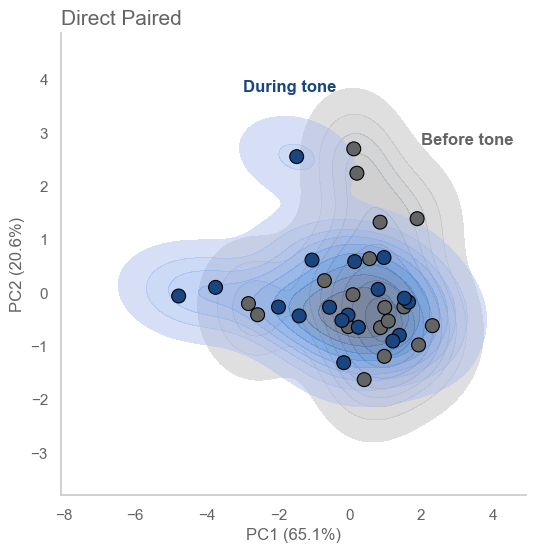

In [25]:
specific_condition = {
    'learning': 'mediated',
    'group': 'unpaired'
    }

ax, embedding_dataset, dataframe_for_titles, concat_hue, pca= visuals_customized.plot_embeddings_timelapse(
    my_deepof_project,
    supervised_annotations=supervised_annotation,
    bin_size=60,
    bin_index_list=[2,3],
    my_title = 'Direct Paired',
    my_color_dict = color_dict,
    my_coords_dict = coords_dict,
    specific_condition = specific_condition,
    given_pca = pca # Comment to train a new pca
)

In [26]:
from scipy.stats import zscore
import numpy as np

# Detect outliers
outliers = []

bin2 = embedding_dataset[embedding_dataset['experimental condition'] == 'bin2']
bin2['zscore'] = abs(zscore(bin2['PCA-1']))
bin2['outlier'] = bin2.zscore > 2
for index, row in bin2.iterrows():
    if row['outlier']:
        outliers.append(index)

bin3 = embedding_dataset[embedding_dataset['experimental condition'] == 'bin3']
bin3['zscore'] = abs(zscore(bin3['PCA-1']))
bin3['outlier'] = bin3.zscore > 2
for index, row in bin3.iterrows():
    if row['outlier']:
        outliers.append(index)

new_outliers = []
for outlier in outliers:
    if outlier[-1] == '2':
        new_outliers.append(outlier)
        new_outliers.append(outlier[:-1] + '3')
    elif outlier[-1] == '3':
        new_outliers.append(outlier)
        new_outliers.append(outlier[:-1] + '2')

C:\Users\mcanela\AppData\Local\Temp\ipykernel_12760\776676557.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin2['zscore'] = abs(zscore(bin2['PCA-1']))
C:\Users\mcanela\AppData\Local\Temp\ipykernel_12760\776676557.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin2['outlier'] = bin2.zscore > 2
C:\Users\mcanela\AppData\Local\Temp\ipykernel_12760\776676557.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

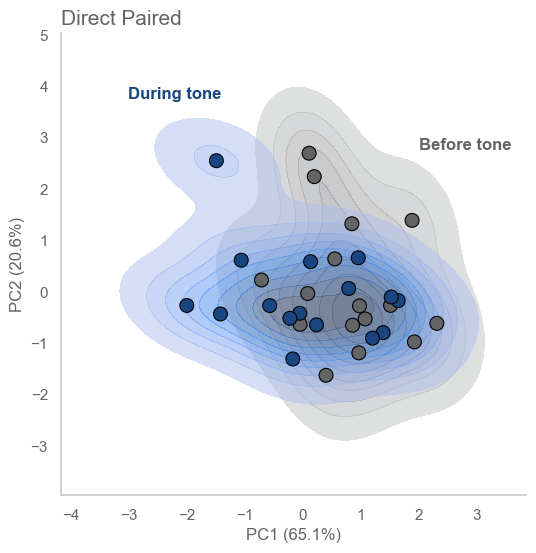

In [27]:
ax, embedding_dataset, dataframe_for_titles, concat_hue, pca= visuals_customized.plot_embeddings_timelapse(
    my_deepof_project,
    supervised_annotations=supervised_annotation,
    bin_size=60,
    bin_index_list=[2,3],
    my_title = 'Direct Paired',
    my_color_dict = color_dict,
    my_coords_dict = coords_dict,
    specific_condition = specific_condition,
    given_pca = pca, # Comment to train a new pca
    outliers = new_outliers
)

### Analyze individual PC, rotated_loading_scores (across time) 

In [28]:
pg.normality(embedding_dataset, 'PCA-1', 'experimental condition')

,W,pval,normal
experimental condition,,,
bin2,0.973913,0.897310,True
bin3,0.950812,0.502667,True


In [34]:
pg.wilcoxon(list(embedding_dataset[embedding_dataset['experimental condition'] == 'bin2']['PCA-1']),
            list(embedding_dataset[embedding_dataset['experimental condition'] == 'bin3']['PCA-1']))

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,17.0,two-sided,0.006287,0.75,0.691406


In [29]:
pg.homoscedasticity(embedding_dataset, 'PCA-1', 'experimental condition')

,W,pval,equal_var
levene,2.24641,0.144375,True


In [30]:
x = embedding_dataset[embedding_dataset['experimental condition'] == 'bin2']['PCA-1']
y = embedding_dataset[embedding_dataset['experimental condition'] == 'bin3']['PCA-1']
pg.ttest(x, y, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.10278,15,two-sided,0.007276,"[0.24, 1.27]",0.757377,7.117,0.808142


In [31]:
# Save your statistics in a dictionary
stats_dict = {
    #'': ['bin0', 'bin1'],
    #'': ['bin0', 'bin2'],
    '∗∗∗': ['Before', 'During'],
    }

\\folder\becell\Lab Projects\ERCstG_HighMemory\Data\Marc\github\deepof_abg\visuals_customized.py:3358: UserWarning: Glyph 8727 (\N{ASTERISK OPERATOR}) missing from current font.
  plt.tight_layout()


<Axes: ylabel='PCA-1 eigenvalues'>

c:\Users\mcanela\AppData\Local\miniconda3\envs\deepof\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 8727 (\N{ASTERISK OPERATOR}) missing from current font.
  func(*args, **kwargs)
c:\Users\mcanela\AppData\Local\miniconda3\envs\deepof\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8727 (\N{ASTERISK OPERATOR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


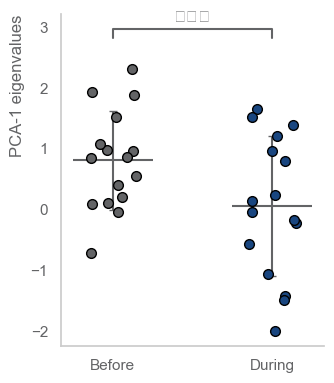

In [33]:
# Plot the PC components
visuals_customized.boxplot(embedding_dataset, color_dict, 'PCA-1', stats_dict, 'experimental condition')

<Axes: xlabel='PCA-1 rotated loading scores'>

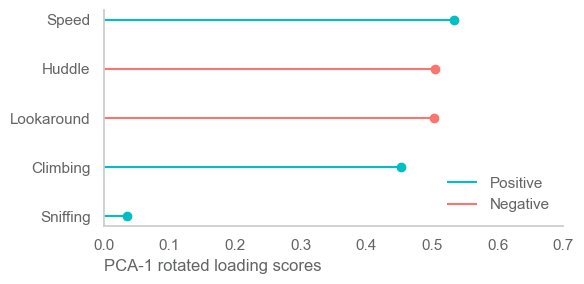

In [16]:
# Plot the rotated loading scores of PC components
rotated_loading_scores = pca.components_
visuals_customized.lollipop(dataframe_for_titles, rotated_loading_scores, 'PCA-1')

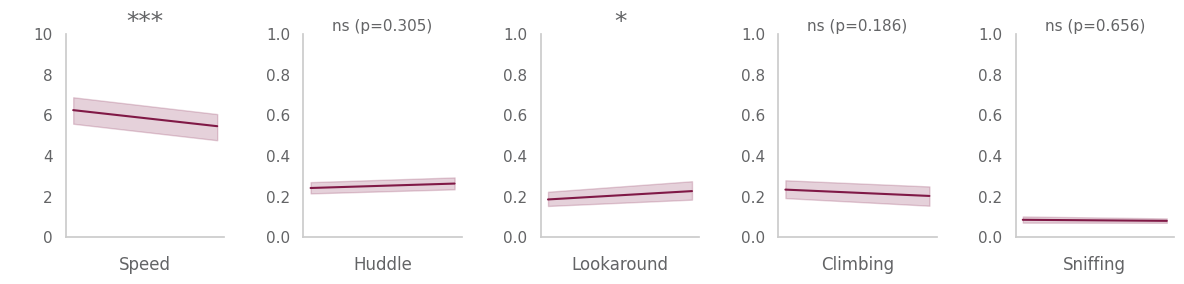

In [51]:
# Plot some individual behaviors over bins
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12, 3))

visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'speed', 0, 10, red, ax=ax1)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'huddle', 0, 1, red, ax=ax2)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'lookaround', 0, 1, red, ax=ax3)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'climbing', 0, 1, red, ax=ax4)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'sniffing', 0, 1, red, ax=ax5)

plt.tight_layout()
plt.show()